In [2]:
 !pip install Sastrawi
# # !apt-get
!pip install tensorflow==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled

# Import Library

In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.1


In [1]:
import numpy as np
import pandas as pd
import re
import json
import keras
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, SpatialDropout1D
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
indo = stopwords.words('indonesian')

from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Define Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
BASE_PATH = "/content/drive/MyDrive/LSTM_DAPA/"
MODELS_PATH = BASE_PATH + "models/"
DATASET_PATH = BASE_PATH + "dataset/"
LIBRARY_PATH = BASE_PATH + "library/"
HISTORY_PATH = BASE_PATH + "history/"

# Load Data

In [ ]:
data = pd.read_excel(DATASET_PATH + "Data Twitter Uncleaned.xlsx")

data

In [ ]:
data = data.dropna(subset=['label']) # Menghapus label yang kosong
data = data[['text','label']].reset_index(drop=True)
data['label'] = data[['label']].replace({1:0,2:1,3:2,4:3,5:4})

data

In [ ]:
data['label'].value_counts()

- 0 : Dislike
- 1 : Fear
- 2 : Joy
- 3 : Sadness
- 4 : Enthusiast

# Pre Processing

In [2]:
df_slang_okky = pd.read_csv('https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/new_kamusalay.csv',encoding='latin-1', header=None)
df_slang_okky.rename(columns={0:'slang', 1:'normal'}, inplace=True)
dict_slang_okky = dict(zip(df_slang_okky['slang'], df_slang_okky['normal']))
df_dict_slang_okky = pd.DataFrame.from_dict(dict_slang_okky, orient='index', columns=['normal']).reset_index()

df_dict_slang_okky.sample(5)

,index,normal
3049,nepu,empu
4179,siapsableng,siap sableng
7921,martabakk,martabak
13905,jerit2,jerit jerit
323,blh,boleh


In [3]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [4]:
def case_folding(text):
    text = text.lower()
    return text

def cleaning(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('indonesian'))
    tokens = [word for word in tokens if word not in stop_words]

    normalized_text = ' '.join(tokens)
    return normalized_text

def normalize(text):
    text =  ' '.join([dict_slang_okky[word] if word in dict_slang_okky else word for word in text.split(' ')])
    text = stemmer.stem(text)
    return text

In [ ]:
# # Proses Cleaning Data
data['text_clean'] = data['text'].apply(case_folding)
data['text_clean'] = data['text_clean'].apply(cleaning)
data['text_clean'] = data['text_clean'].apply(normalize)

In [ ]:
data

In [ ]:
# data.to_csv(DATASET_PATH + 'data_twitter_cleaned.csv', index=False)

print("Data saved!")

## Train Test Split

In [4]:
data = pd.read_csv(DATASET_PATH + 'data_twitter_cleaned.csv')
data = data[['label', 'text_clean']]

data

,label,text_clean
0,1.0,genting kosong tertawa mobil listrik emisi ten...
1,0.0,planning united state of america pakai plannin...
2,0.0,mobil listrik bagus lingkung mahal mobil bahan...
3,1.0,bahasa kamu gambar betapa rendah diri mobil li...
4,1.0,tunggu charge mobil listrik menit sudah full a...
...,...,...
2507,4.0,indonesia pabrik baterry listrik batery besar ...
2508,4.0,baterai mobil listrik baterai lithium ion baha...
2509,4.0,tahu bang mobil listrik pakenya lithium tesla ...
2510,4.0,santai drun bagus nya jokowi bikin badan usaha...


In [5]:
data.isna().sum()

,0
label,11
text_clean,0


In [6]:
data.dropna(inplace=True)

In [7]:
data.isna().sum()

,0
label,0
text_clean,0


In [8]:
data['label'] = data['label'].astype(int)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2501 entries, 0 to 2511
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       2501 non-null   int64 
 1   text_clean  2501 non-null   object
dtypes: int64(1), object(1)
memory usage: 58.6+ KB


In [10]:
data

,label,text_clean
0,1,genting kosong tertawa mobil listrik emisi ten...
1,0,planning united state of america pakai plannin...
2,0,mobil listrik bagus lingkung mahal mobil bahan...
3,1,bahasa kamu gambar betapa rendah diri mobil li...
4,1,tunggu charge mobil listrik menit sudah full a...
...,...,...
2507,4,indonesia pabrik baterry listrik batery besar ...
2508,4,baterai mobil listrik baterai lithium ion baha...
2509,4,tahu bang mobil listrik pakenya lithium tesla ...
2510,4,santai drun bagus nya jokowi bikin badan usaha...


In [11]:
# data.to_csv(DATASET_PATH + 'data_twitter_cleaned_label.csv', index=False)

In [12]:
replace_value = {
    0: 'Dislike',
    1: 'Fear',
    2: 'Joy',
    3: 'Sadness',
    4: 'Enthusiast'
    }

data['label'] = data['label'].replace(replace_value)
data['label'].value_counts()

,count
label,
Enthusiast,1133
Dislike,665
Sadness,397
Fear,153
Joy,153


In [13]:
data.head()

,label,text_clean
0,Fear,genting kosong tertawa mobil listrik emisi ten...
1,Dislike,planning united state of america pakai plannin...
2,Dislike,mobil listrik bagus lingkung mahal mobil bahan...
3,Fear,bahasa kamu gambar betapa rendah diri mobil li...
4,Fear,tunggu charge mobil listrik menit sudah full a...


In [14]:
df_encoded = pd.get_dummies(data, columns=['label'])
df_encoded

,text_clean,label_Dislike,label_Enthusiast,label_Fear,label_Joy,label_Sadness
0,genting kosong tertawa mobil listrik emisi ten...,False,False,True,False,False
1,planning united state of america pakai plannin...,True,False,False,False,False
2,mobil listrik bagus lingkung mahal mobil bahan...,True,False,False,False,False
3,bahasa kamu gambar betapa rendah diri mobil li...,False,False,True,False,False
4,tunggu charge mobil listrik menit sudah full a...,False,False,True,False,False
...,...,...,...,...,...,...
2507,indonesia pabrik baterry listrik batery besar ...,False,True,False,False,False
2508,baterai mobil listrik baterai lithium ion baha...,False,True,False,False,False
2509,tahu bang mobil listrik pakenya lithium tesla ...,False,True,False,False,False
2510,santai drun bagus nya jokowi bikin badan usaha...,False,True,False,False,False


In [15]:
df_label = ["label_Dislike", "label_Enthusiast", "label_Fear", "label_Joy", "label_Sadness"]

for i in df_label:
    df_encoded[i] = df_encoded[i].astype(int)

In [16]:
display(df_encoded['label_Dislike'].value_counts())
display(df_encoded['label_Enthusiast'].value_counts())
display(df_encoded['label_Fear'].value_counts())
display(df_encoded['label_Joy'].value_counts())
display(df_encoded['label_Sadness'].value_counts())

,count
label_Dislike,
0,1836
1,665


,count
label_Enthusiast,
0,1368
1,1133


,count
label_Fear,
0,2348
1,153


,count
label_Joy,
0,2348
1,153


,count
label_Sadness,
0,2104
1,397


In [17]:
df_encoded

,text_clean,label_Dislike,label_Enthusiast,label_Fear,label_Joy,label_Sadness
0,genting kosong tertawa mobil listrik emisi ten...,0,0,1,0,0
1,planning united state of america pakai plannin...,1,0,0,0,0
2,mobil listrik bagus lingkung mahal mobil bahan...,1,0,0,0,0
3,bahasa kamu gambar betapa rendah diri mobil li...,0,0,1,0,0
4,tunggu charge mobil listrik menit sudah full a...,0,0,1,0,0
...,...,...,...,...,...,...
2507,indonesia pabrik baterry listrik batery besar ...,0,1,0,0,0
2508,baterai mobil listrik baterai lithium ion baha...,0,1,0,0,0
2509,tahu bang mobil listrik pakenya lithium tesla ...,0,1,0,0,0
2510,santai drun bagus nya jokowi bikin badan usaha...,0,1,0,0,0


In [18]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2501 entries, 0 to 2511
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   text_clean        2501 non-null   object
 1   label_Dislike     2501 non-null   int64 
 2   label_Enthusiast  2501 non-null   int64 
 3   label_Fear        2501 non-null   int64 
 4   label_Joy         2501 non-null   int64 
 5   label_Sadness     2501 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 136.8+ KB


In [19]:
df_encoded.head()

,text_clean,label_Dislike,label_Enthusiast,label_Fear,label_Joy,label_Sadness
0,genting kosong tertawa mobil listrik emisi ten...,0,0,1,0,0
1,planning united state of america pakai plannin...,1,0,0,0,0
2,mobil listrik bagus lingkung mahal mobil bahan...,1,0,0,0,0
3,bahasa kamu gambar betapa rendah diri mobil li...,0,0,1,0,0
4,tunggu charge mobil listrik menit sudah full a...,0,0,1,0,0


In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded["text_clean"],
                                                    df_encoded.drop(columns='text_clean'),
                                                    test_size=0.2,
                                                    random_state=42)

In [21]:
print(f"{len(X_train)} sentences for training")
print(f"{len(X_test)} labels for training")
print(f"{len(y_train)} sentences for validation")
print(f"{len(y_test)} labels for validation.")

2000 sentences for training
501 labels for training
2000 sentences for validation
501 labels for validation.


## Tokenizing

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [23]:
X_train = pad_sequences(X_train, maxlen=100)
X_test = pad_sequences(X_test, maxlen=100)

In [24]:
# Load the GloVe embeddings
embeddings_index = {}
with open(LIBRARY_PATH + "glove.id.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [25]:
# Create the embedding matrix
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [26]:
MAXLEN =100

X_train = pad_sequences(X_train, padding='post', maxlen=MAXLEN)
X_test = pad_sequences(X_test, padding='post', maxlen=MAXLEN)

In [27]:
X_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,  510,  722, 2207,  565,   16,
         24], dtype=int32)

In [28]:
X_test[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,   88,  316,    2,  667,   41,    1,  135,  454, 1064,    2,
       3858], dtype=int32)

In [29]:
embedding_matrix.shape

(5068, 100)

# Modeling LSTM

In [30]:
class TrainingHistory(Callback):
    def __init__(self):
        super(TrainingHistory, self).__init__()
        self.history = {
            'accuracy': [],
            'val_accuracy': [],
            'loss': [],
            'val_loss': []
        }

    def on_epoch_end(self, epoch, logs=None):
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))

def function_checkpoint_callback(checkpoint_path):
    checkpoint_callback = ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        # save_best_only=True,
        mode='max',
        verbose=1
    )
    return checkpoint_callback

print("Callbacks succesfully created!")

Callbacks succesfully created!


In [31]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, 100, weights=[embedding_matrix], input_length=MAXLEN, trainable=False),
    tf.keras.layers.SpatialDropout1D(0.001),
    tf.keras.layers.LSTM(100, dropout=0.5, recurrent_dropout=0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
print('Model has been builded!')

Model has been builded!


In [32]:
model_lstm.compile(loss='categorical_crossentropy',
                   optimizer=keras.optimizers.Adam(learning_rate=0.001),
                   metrics=['accuracy'])

model_lstm.summary()
print('Model has been compiled!')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          506800    
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 100)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 587705 (2.24 MB)
Trainable params: 80905 (316.04 KB)
Non-trainable params: 506800 (1.93 MB)
_________________________________________________________________
Model has been compiled!


In [33]:
df_encoded.head()

,text_clean,label_Dislike,label_Enthusiast,label_Fear,label_Joy,label_Sadness
0,genting kosong tertawa mobil listrik emisi ten...,0,0,1,0,0
1,planning united state of america pakai plannin...,1,0,0,0,0
2,mobil listrik bagus lingkung mahal mobil bahan...,1,0,0,0,0
3,bahasa kamu gambar betapa rendah diri mobil li...,0,0,1,0,0
4,tunggu charge mobil listrik menit sudah full a...,0,0,1,0,0


In [34]:
history_callback = TrainingHistory()
EPOCHS = 30
batch_size = 128

history = model_lstm.fit(X_train,
                         y_train,
                         epochs=EPOCHS,
                         batch_size=batch_size,
                         validation_split=0.2,
                         verbose=2,
                         callbacks=[
                             history_callback,
                             function_checkpoint_callback(MODELS_PATH + "model_lstm_fix_v5.h5")])


Epoch 1/30

Epoch 1: saving model to /content/drive/MyDrive/LSTM_DAPA/models/model_lstm_fix_v5.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 - 10s - loss: 1.4654 - accuracy: 0.3931 - val_loss: 1.2918 - val_accuracy: 0.4975 - 10s/epoch - 736ms/step
Epoch 2/30

Epoch 2: saving model to /content/drive/MyDrive/LSTM_DAPA/models/model_lstm_fix_v5.h5
13/13 - 6s - loss: 1.3381 - accuracy: 0.4750 - val_loss: 1.2313 - val_accuracy: 0.5150 - 6s/epoch - 477ms/step
Epoch 3/30

Epoch 3: saving model to /content/drive/MyDrive/LSTM_DAPA/models/model_lstm_fix_v5.h5
13/13 - 4s - loss: 1.2824 - accuracy: 0.4975 - val_loss: 1.1755 - val_accuracy: 0.5550 - 4s/epoch - 340ms/step
Epoch 4/30

Epoch 4: saving model to /content/drive/MyDrive/LSTM_DAPA/models/model_lstm_fix_v5.h5
13/13 - 5s - loss: 1.2602 - accuracy: 0.5069 - val_loss: 1.1878 - val_accuracy: 0.5475 - 5s/epoch - 416ms/step
Epoch 5/30

Epoch 5: saving model to /content/drive/MyDrive/LSTM_DAPA/models/model_lstm_fix_v5.h5
13/13 - 6s - loss: 1.2261 - accuracy: 0.5288 - val_loss: 1.1540 - val_accuracy: 0.5750 - 6s/epoch - 427ms/step
Epoch 6/30

Epoch 6: saving model to /content/drive

In [35]:
with open(HISTORY_PATH + "model_lstm_fix_v5.json", 'w') as f:
    json.dump(history_callback.history, f)

# Save model
print("History Saved!")

History Saved!


# Load Models

In [36]:
# Load Models
model_lstm = tf.keras.models.load_model(MODELS_PATH + "model_lstm_fix_v5.h5")

# Load History
with open(HISTORY_PATH + "model_lstm_fix_v5.json", 'r') as f:
    history_lstm = json.load(f)

print("Model & History Loaded!")

Model & History Loaded!


# Evaluate Models

In [37]:
def plot_training(hist):

    tr_acc = hist['accuracy']
    tr_loss = hist['loss']
    val_acc = hist['val_accuracy']
    val_loss = hist['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]

    plt.figure(figsize= (30, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

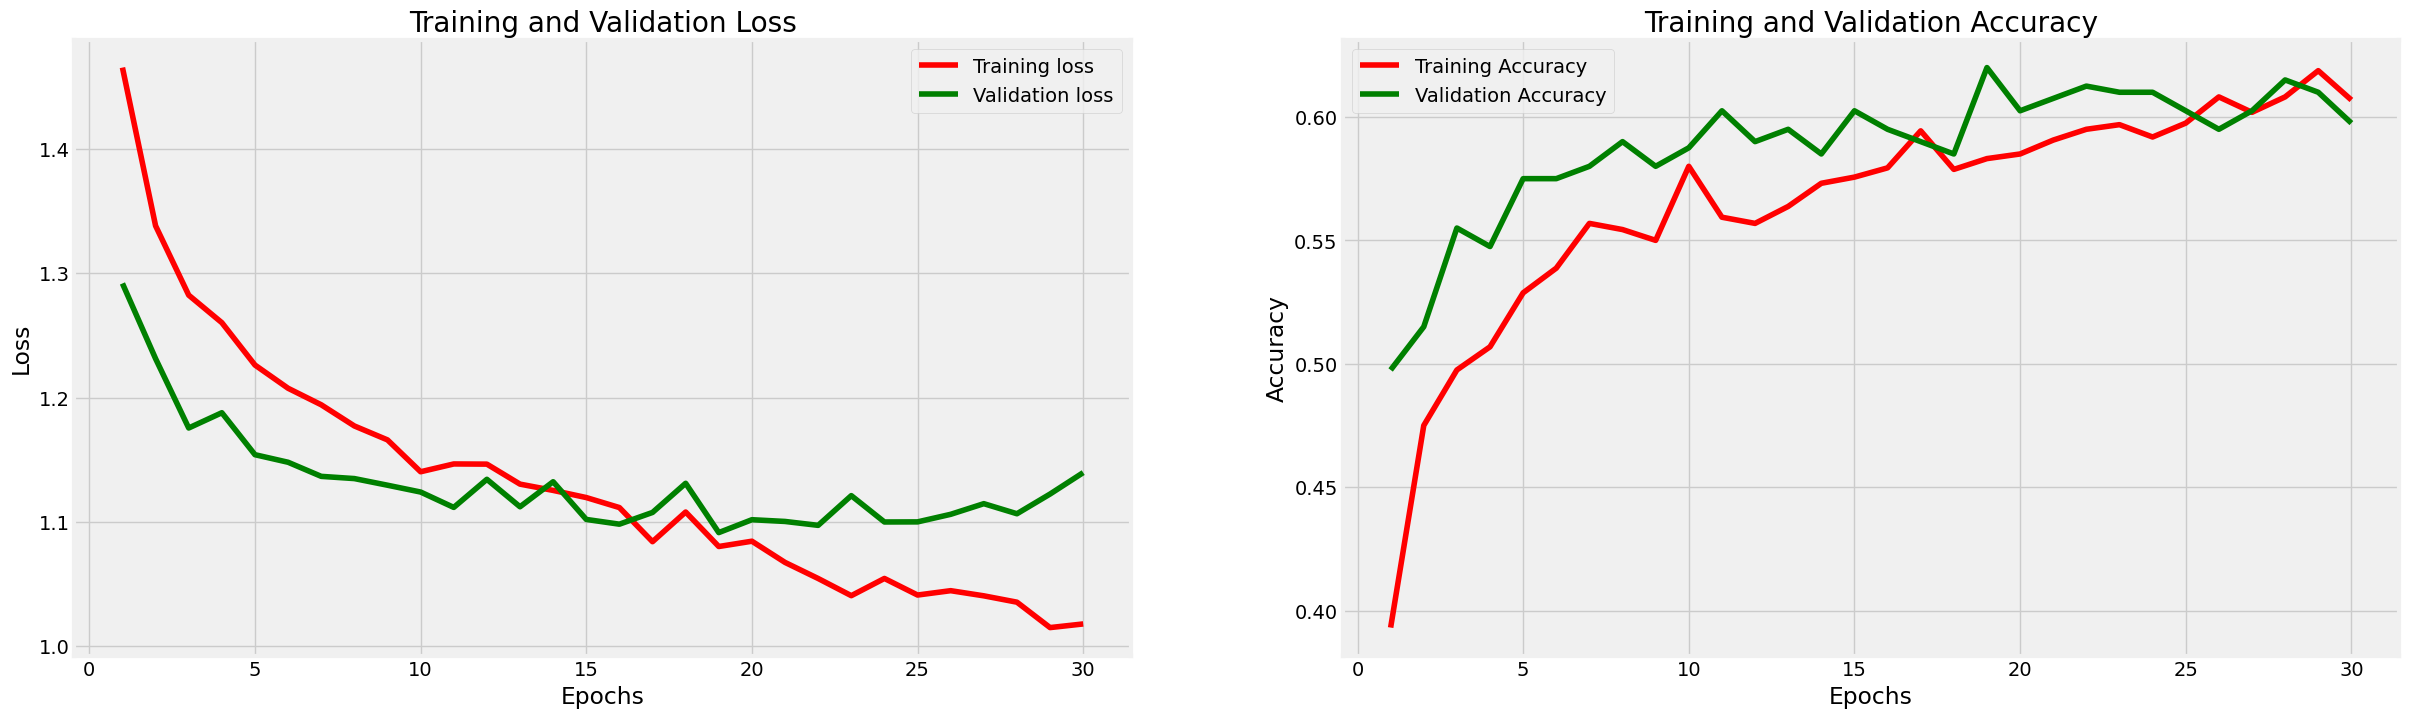

In [38]:
plot_training(history_lstm)

In [39]:
# Calculating Accuracy - Train Data
loss, accuracy = model_lstm.evaluate(X_train, y_train)

print("The loss is: ", loss)
print("The accuracy is: ", accuracy)

evaluate_model_train = pd.DataFrame({
    'Models': ['LSTM Training'],
    'Accuracy': [accuracy],
    'Loss': [loss]
})

display(evaluate_model_train)

63/63 [==============================] - 2s 28ms/step - loss: 0.9571 - accuracy: 0.6395
The loss is:  0.9571467041969299
The accuracy is:  0.6395000219345093


,Models,Accuracy,Loss
0,LSTM Training,0.6395,0.957147


In [40]:
# Calculating Accuracy - Test Data
loss, accuracy = model_lstm.evaluate(X_test, y_test)

print("The loss is: ", loss)
print("The accuracy is: ", accuracy)

evaluate_model_test = pd.DataFrame({
    'Models': ['LSTM Testing'],
    'Accuracy': [accuracy],
    'Loss': [loss]
})

display(evaluate_model_test)

16/16 [==============================] - 1s 30ms/step - loss: 1.1647 - accuracy: 0.5649
The loss is:  1.1647067070007324
The accuracy is:  0.5648702383041382


,Models,Accuracy,Loss
0,LSTM Testing,0.56487,1.164707


In [41]:
y_pred = np.argmax(model_lstm.predict(X_test), axis=1)
y = np.argmax(np.array(y_test), axis=1)

labels = ['Dislike', 'Enthusiast', 'Fear', 'Joy', 'Sadness']
print(classification_report(y, y_pred, target_names=labels))

16/16 [==============================] - 1s 32ms/step
              precision    recall  f1-score   support

     Dislike       0.47      0.54      0.51       134
  Enthusiast       0.60      0.82      0.70       234
        Fear       0.00      0.00      0.00        29
         Joy       0.00      0.00      0.00        24
     Sadness       0.64      0.23      0.33        80

    accuracy                           0.56       501
   macro avg       0.34      0.32      0.31       501
weighted avg       0.51      0.56      0.51       501



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


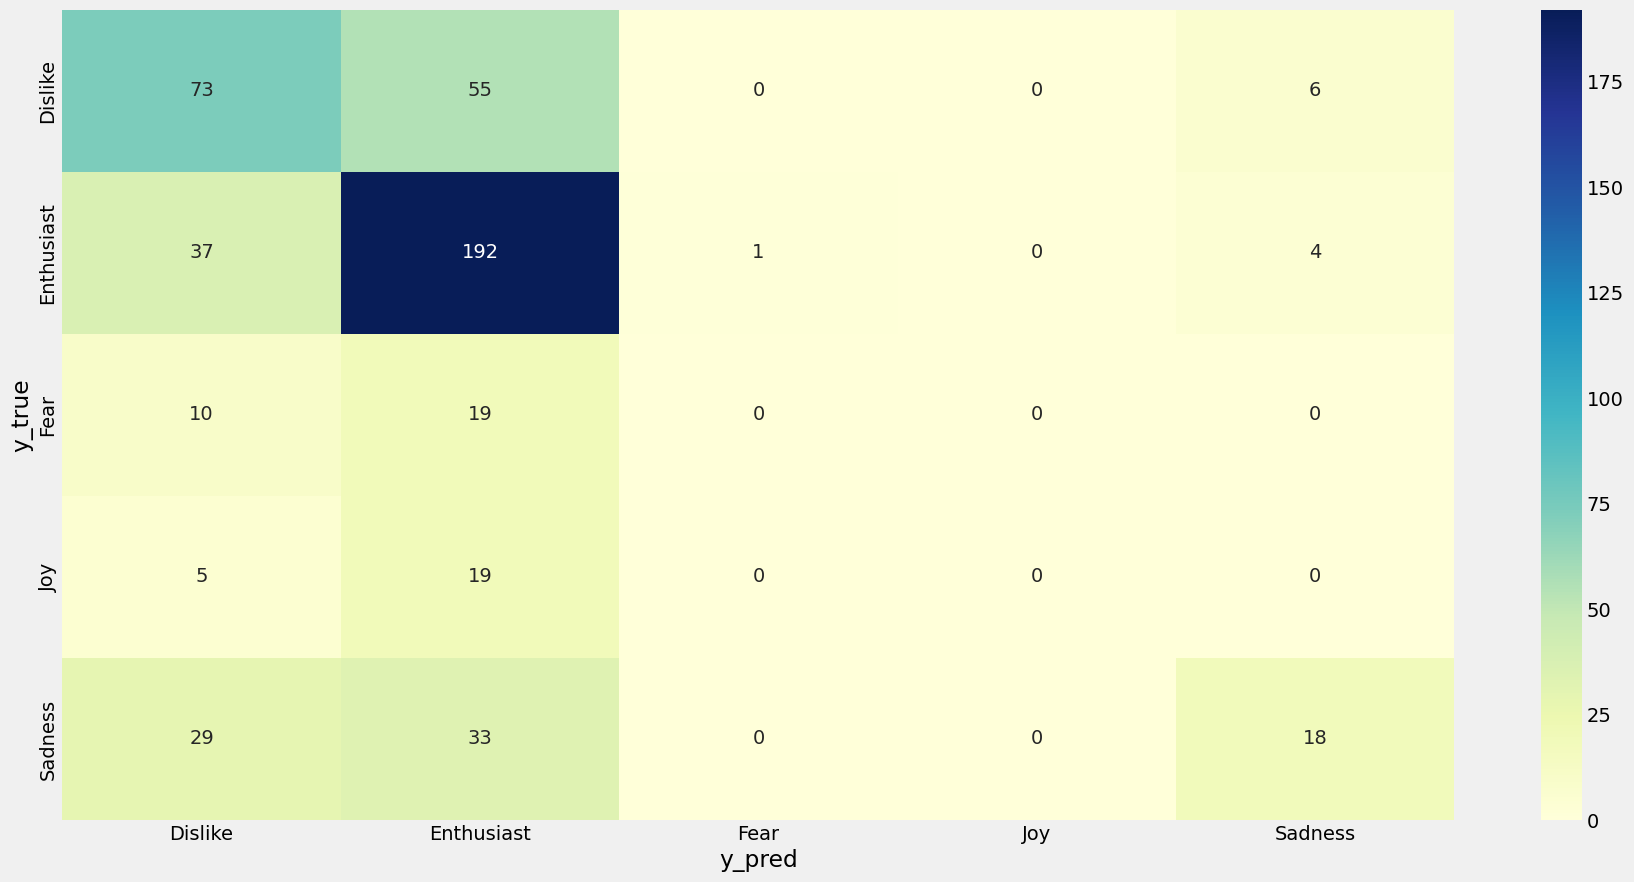

In [42]:
labels = ['Dislike', 'Enthusiast', 'Fear', 'Joy', 'Sadness']

cm = confusion_matrix(y, y_pred)
df_cm = pd.DataFrame(cm, index = labels, columns = labels)

f, ax=plt.subplots(figsize=(20,10))
sns.heatmap(df_cm, annot=True,cmap='YlGnBu', fmt='d')
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

# Predictive System

In [43]:
labels = ['Dislike', 'Enthusiast', 'Fear', 'Joy', 'Sadness']

def predict(text):
  input = []
  input.append(text)
  seq = tokenizer.texts_to_sequences(input)
  padded = pad_sequences(seq, maxlen=100)
  pred = model_lstm.predict(padded)

  return pred, labels[np.argmax(pred)], f"{np.round(np.max(pred)*100, 2)}%"

In [44]:
predict('mobil listrik ini jelek sekali, tidak mau saya membelinya')

1/1 [==============================] - 0s 35ms/step


(array([[0.54947937, 0.17758071, 0.12645245, 0.04225273, 0.10423475]],
       dtype=float32),
 'Dislike',
 '54.95%')

In [45]:
predict('saya sangat gembira melihat mobil listrik sudah banyak di Indonesia')

1/1 [==============================] - 0s 36ms/step


(array([[0.19903918, 0.4169437 , 0.08911045, 0.15693101, 0.13797556]],
       dtype=float32),
 'Enthusiast',
 '41.69%')

In [46]:
predict("Keren mobil listrik ini")

1/1 [==============================] - 0s 30ms/step


(array([[0.16388878, 0.6000506 , 0.07673021, 0.08961294, 0.06971742]],
       dtype=float32),
 'Enthusiast',
 '60.01%')

# Result Models

In [47]:
result_models = pd.concat([evaluate_model_train,
                           evaluate_model_test], ignore_index=True)

result_models.sort_values(by='Accuracy', ascending=False)

,Models,Accuracy,Loss
0,LSTM Training,0.63950,0.957147
1,LSTM Testing,0.56487,1.164707
